# Predicting Cat and Dog Adoptions at the AAC (Austin Animal Center)
***
***

# Goals <a id='goals'></a>
***

This project has 3 main goals:
- Create a model that will acurrately predict which cats and dogs will be adopted from the Austin Animal Center
- Develop insights about what affects cat and dog adoptions
- Develop insights about the activity at the AAC in general (when are intake counts high/low?, etc.)

I will also deliver the following: 
- aac_project_notebook.ipynb
    - This notebook which provides a start-to-finish walkthrough of the project
- README.md
    - A markdown file that provides various information about this project including a data dictionary, project plan, and a link to the source data
- wrangle.py
    - A file that contains all of the custom functions featured in this notebook
- A presentation of the project
    - A 3-5 minute presentation that summarizes the findings of this project (link to presentation slides below)
        - https://docs.google.com/presentation/d/1KTZ6N8kW-pXHV-GPKc_N_vQAmfRyqcuD25e6xDMk4mo/edit?usp=sharing

In [1]:
# establishing environment
import sklearn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from wrangle import get_aac, prep_aac, wrangle_aac

# Acquire<a id='acquire'></a>
I'll begin by acquiring the data from a local CSV file. The data I'm using can be accessed via a link in the README file of this repository.
***

In [2]:
# reading data in as DF
df = get_aac()

# previewing data
df.head()

,age_upon_outcome,animal_id_outcome,date_of_birth,outcome_subtype,outcome_type,sex_upon_outcome,age_upon_outcome_(days),age_upon_outcome_(years),age_upon_outcome_age_group,outcome_datetime,...,age_upon_intake_age_group,intake_datetime,intake_month,intake_year,intake_monthyear,intake_weekday,intake_hour,intake_number,time_in_shelter,time_in_shelter_days
0,10 years,A006100,2007-07-09 00:00:00,NaN,Return to Owner,Neutered Male,3650,10.0,"(7.5, 10.0]",2017-12-07 14:07:00,...,"(7.5, 10.0]",2017-12-07 00:00:00,12,2017,2017-12,Thursday,14,1.0,0 days 14:07:00.000000000,0.588194
1,7 years,A006100,2007-07-09 00:00:00,NaN,Return to Owner,Neutered Male,2555,7.0,"(5.0, 7.5]",2014-12-20 16:35:00,...,"(5.0, 7.5]",2014-12-19 10:21:00,12,2014,2014-12,Friday,10,2.0,1 days 06:14:00.000000000,1.259722
2,6 years,A006100,2007-07-09 00:00:00,NaN,Return to Owner,Neutered Male,2190,6.0,"(5.0, 7.5]",2014-03-08 17:10:00,...,"(5.0, 7.5]",2014-03-07 14:26:00,3,2014,2014-03,Friday,14,3.0,1 days 02:44:00.000000000,1.113889
3,10 years,A047759,2004-04-02 00:00:00,Partner,Transfer,Neutered Male,3650,10.0,"(7.5, 10.0]",2014-04-07 15:12:00,...,"(7.5, 10.0]",2014-04-02 15:55:00,4,2014,2014-04,Wednesday,15,1.0,4 days 23:17:00.000000000,4.970139
4,16 years,A134067,1997-10-16 00:00:00,NaN,Return to Owner,Neutered Male,5840,16.0,"(15.0, 17.5]",2013-11-16 11:54:00,...,"(15.0, 17.5]",2013-11-16 09:02:00,11,2013,2013-11,Saturday,9,1.0,0 days 02:52:00.000000000,0.119444


### Acquire Takeaways
- Acquired data from local csv file using pandas __read_csv__ function
- Data can also be acquired via the __wrangle_aac__ function in the __wrangle.py__ file
    - Note that the __wrangle_aac__ function will also prep the data for exploration

# Prepare<a id='prepare'></a>
I'm now going to prepare the data for exploration.
***

In [3]:
# previewing data for null value counts and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79672 entries, 0 to 79671
Data columns (total 41 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   age_upon_outcome            79672 non-null  object 
 1   animal_id_outcome           79672 non-null  object 
 2   date_of_birth               79672 non-null  object 
 3   outcome_subtype             36348 non-null  object 
 4   outcome_type                79662 non-null  object 
 5   sex_upon_outcome            79671 non-null  object 
 6   age_upon_outcome_(days)     79672 non-null  int64  
 7   age_upon_outcome_(years)    79672 non-null  float64
 8   age_upon_outcome_age_group  79672 non-null  object 
 9   outcome_datetime            79672 non-null  object 
 10  outcome_month               79672 non-null  int64  
 11  outcome_year                79672 non-null  int64  
 12  outcome_monthyear           79672 non-null  object 
 13  outcome_weekday             796

### Prepping Data via prep_aac function

In [4]:
# prepping data with changes outlined in prepare takeaway section (below)
train, validate, test = prep_aac(df)

In [5]:
# previewing train df
train.head()

,perceived_agg_breed,is_cat,is_dog,species,is_male,is_female,gender_unknown,gender,sterilized_income,outcome_subtype,outcome_type,age_group_years,age_outcome_days,age_outcome_days_s,is_adopted
41664,0,0,1,dog,1,0,0,Male,1,unknown,Adoption,a.0-1,60,0.008219,1
8001,1,0,1,dog,1,0,0,Male,1,Partner,Transfer,a.0-1,365,0.050000,0
70226,0,0,1,dog,0,1,0,Female,0,unknown,Adoption,b.2-3,730,0.100000,1
70696,0,1,0,cat,0,1,0,Female,0,Foster,Adoption,a.0-1,90,0.012329,1
39646,0,1,0,cat,1,0,0,Male,0,Partner,Transfer,a.0-1,21,0.002877,0


### Prepare Takeaways
After reviewing the data for this project, I elected to make the following changes by creating a function, __prep_aac__, located in the __wrangle.py file__. 

Alternatively, the __wrangle_aac__ function from the __wrangle.py file__ can be ran to both acquire and prep the data with a single function.

- __Dropped columns that will not be used in this iteration of project (to preserve time) but may be explored in future iteration__
    - animal_id_outcome | animal_id_intake | outcome_number | intake_number
        - Could prove useful in allowing me to track animals that visit the AAC multiple times
    - outcome_datetime | outcome_month | outcome_year | outcome_monthyear | outcome_weekday | outcome_hour
        - Would be interesting to see if there are time periods when adoptions spike / dip
    - age_upon_intake_(days) |found_location | intake_condition | intake_type | intake_datetime | time_in_shelter_days
        - Do these variables correlate with any other features or outcomes? 
    - color
        - Are some color / animal combinations adopted more often?
        
        
- __Dropped columns that were not needed since the value of their information can be derived from other columns__
    - date_of_birth | age_upon_outcome | age_upon_outcome_(years) | age_upon_outcome_age_group | dob_year | dob_month | dob_monthyear | age_upon_intake_(years) | age_upon_intake | age_upon_intake_age_group |  intake_month | intake_year | intake_monthyear | intake_weekday | intake_hour | time_in_shelter | age_group_year 


- __Other changes__
- Dropped "count" column
    - created by uploader of data to Kaggle, not useful for this project
- Renamed age_upon_outcome_(days) to age_outcome_days
- Renamed animal_type to species
- Created "perceived_agg_breed" column that reflects if animal is of breed that is commonly perceived as aggressive (chow, doberman, pitbull, rottweiler)
- Created scaled versions of age_outcome_days column, age_outcome_days_s
- Added age_group_years columns, holds binned values of age in years
- Converted sex_upon_outcome into gender column and created boolean columns for each value within it (male, female, unknown)
    - sex_upon_outcome also contains information about the sterilization status of an animal at the time of outcome but i did not create a column for this data
        - Per the AAC, if an animal wasn't sterilized prior to entering the AAC, they can only be sterilized at the adopters discression upon adoption
        - Thus the AAC wouldn't have the information available to use sterilization status at outcome feature prior prior to animal's adoption.
        - That being said, I'm excluding it as a feature in this project since my goal is to create a model that the AAC could use in a real-world setting
- Add boolean columns for animal type (dog, cat)
- Transform outcome_type to binary categorical column 'is_adopted' 
- Dropped all animals that were not cats or dogs to simplify scope of project and save time
    - Will explore alternate species in next iteration of project
- Dropped rows with outcome type that indicated animal was returned to owner
- Dropped rows with outcome type of "disposal"
    - Rows represent animals that were deceased prior to arrival at AAC, no chance of adoption
- Drop null values
    - Very few nulls so dropping won't have a meaningful impact
- Splitting data into train, validate, and test sets

# Explore<a id='explore'></a>
I'm going to explore the data using plots and hypothesis tests to identify viable features for predicting adoption.
***

## Variable to Explore: Age
Is there a connection between age and adoption? I suspect that older animals are adopted less often.

### Visualization

In [6]:
# setting figure and text size for all plots
sns.set(rc = {'figure.figsize':(12,6)})
sns.set(font_scale = 2)

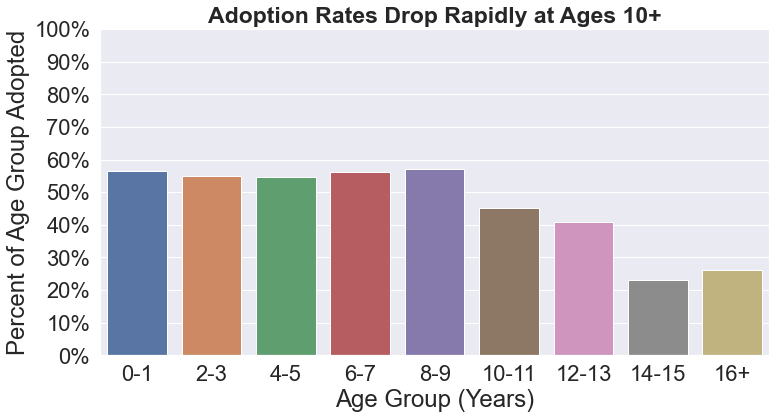

In [7]:
# grouping by age groups (years) and aggregating average % of adopted animals within each group
# sorting by age groups
age_group_adopts = train.groupby('age_group_years').mean()[['is_adopted']].sort_values('age_group_years')

# relabeling index to make x axis ticks simpler
age_group_adopts.index = ['0-1', '2-3', '4-5', '6-7', '8-9', '10-11', '12-13', '14-15', '16+']

# creating plot
sns.barplot(data=age_group_adopts, x=age_group_adopts.index, y='is_adopted')
plt.xlabel("Age Group (Years)")
plt.ylabel("Percent of Age Group Adopted")
plt.title("Adoption Rates Drop Rapidly at Ages 10+", fontweight='bold', fontsize=23)
fmt = [f'{i:0.0%}' for i in np.linspace(0, 1, 11)]
plt.yticks(np.linspace(0, 1, 11), labels=fmt)
plt.show()

### Average % of animals 0 to 9 years old that get adopted?

In [8]:
round(train.groupby('age_group_years').mean()['is_adopted'][0:5].mean(),2)

0.56

### Average % of animals 10 to 16 years old that get adopted?

In [9]:
round(train.groupby('age_group_years').mean()['is_adopted'][5:9].mean(),2)

0.34

### Average % of animals 15+ years old that get adopted?

In [10]:
round(train.groupby('age_group_years').mean()['is_adopted'][7:].mean(),2)

0.25

- Adoption rates between animals ages 0-9 years of age are fairly close


- From age 10 onward, adoption rates drop rapidly


- The age 16+ age group has roughly half the adoption rate of the 0-1 age group

## Two-sample one-tailed t-test
### Hypothesis
<br>
H0: The average age of animals who are adopted is equal to or greater than the average of animals that are not adopted
<br>
Ha: The average age of animals who are adopted is less than the average of animals that are not adopted

In [11]:
# x1 = series of ages of animals who were adopted
# x2 = series of ages of animals who were not adopted
x1 = train[train.is_adopted == 1]['age_outcome_days']
x2 = train[train.is_adopted == 0]['age_outcome_days']

# performing t-test
t, p = stats.ttest_ind(x1, x2)

# printing results
print(f'alpha = .05\n')
print (f'p = {p/2}')
print (f't =',t)

alpha = .05

p = 3.656889348128875e-11
t = -6.516184837764797


- Since p is less than alpha and t is negative I reject the null hypothesis


- The t-test results and visual are both evidence that younger animals are favored over elderly animals for adoption

## Variable to Explore: Species
In terms of percent, is one species adopted more often that the other?

### Comparing adoption rates: cats vs. dogs

In [12]:
# using groupby to examine adoption rates within species
cat_v_dog = train.groupby('species').mean()[['is_adopted']]

cat_v_dog

,is_adopted
species,
cat,0.455803
dog,0.644075


- 45% of all cats are adopted


- 64% of all dogs are adopted

### Visualization

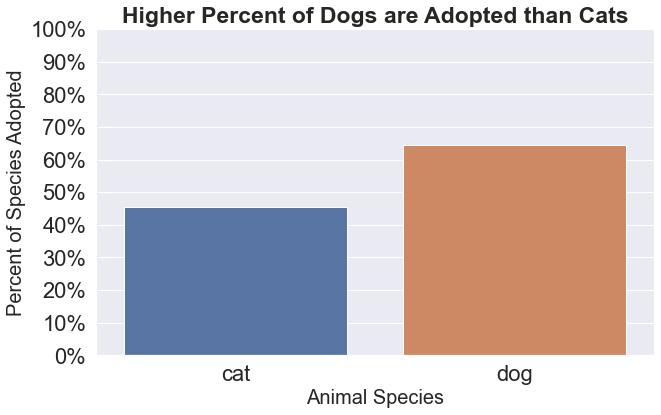

In [13]:
# grouping by species and aggregating % of each species that are adopted
type_adopt = train.groupby('species').mean()[['is_adopted']].sort_values('species')

# creating plot
plt.figure(figsize=(10, 6))
sns.barplot(data = type_adopt, x = type_adopt.index, y='is_adopted')
plt.xlabel("Animal Species", fontsize= 20)
plt.ylabel("Percent of Species Adopted", fontsize= 20)
plt.title("Higher Percent of Dogs are Adopted than Cats", fontweight='bold', fontsize=23)
fmt = [f'{i:0.0%}' for i in np.linspace(0, 1, 11)]
plt.yticks(np.linspace(0, 1, 11), labels=fmt)
plt.show()

### Chi-Squared Test

### Hypothesis
<br>
H0: Adoption and animal type are independent
<br>
Ha: Adoption and animal type are dependent

In [14]:
# creating crosstab of cat adoptions vs dog adoptions
ct_species = pd.crosstab(train.species, train.is_adopted)

# calculating chi^2, p value, degrees of freedom and expected values
chi2, p, degf, expected = stats.chi2_contingency(ct_species)

# printing results
print('alpha = .05\n')
print(f'p = {p:.4f}')

alpha = .05

p = 0.0000


- Since p is less than alpha, I am rejecting the null hypothesis that adopation and animal type are independent


- Based on the average adoption rates between species and bar plot it appears that dogs are favored for adoption over cats

## Variable to Explore: Gender

### Identifying # of unknown gender animals

In [15]:
# using groupby to examine adoption rates within each gender value
male_v_female = train.groupby('gender').mean()[['is_adopted']]

male_v_female

,is_adopted
gender,
Female,0.585855
Male,0.580576
Unknown,0.000000


### Checking total number of cats and dogs with no gender

In [16]:
# counting rows with gender unknown
train[train.gender == 'Unknown'].shape[0]

1559

### Researching unknown gender cats and dogs in depth
Very peculiar that 0 out of nearly 1600 were not adopted

In [17]:
# counting occurences of each outcome type for unknown gender animals
train[train.gender == 'Unknown']['outcome_type'].value_counts()

Transfer      1358
Euthanasia     157
Died            44
Name: outcome_type, dtype: int64

In [18]:
# counting occurences of each outcome subtype for unknown gender animals
train[train.gender == 'Unknown']['outcome_subtype'].value_counts()

Partner        1052
SCRP            244
Suffering       134
Snr              62
In Kennel        28
At Vet           10
In Foster         7
Medical           6
Rabies Risk       6
unknown           5
Enroute           3
Aggressive        1
Underage          1
Name: outcome_subtype, dtype: int64

- All the unknown gender cats and dogs that were not adopted were either transfered, put down, or passed away

### Visualization

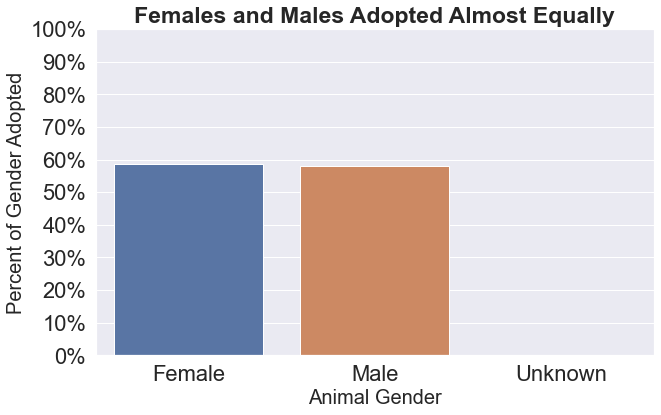

In [19]:
# grouping by gender and aggregating % of adoptions within each gender value
gender_adopt = train.groupby('gender').mean()[['is_adopted']].sort_values('gender')

# plotting 
plt.figure(figsize=(10, 6))
sns.barplot(data = gender_adopt, x = gender_adopt.index, y='is_adopted')
plt.xlabel("Animal Gender", fontsize= 20)
plt.ylabel("Percent of Gender Adopted", fontsize= 20)
plt.title("Females and Males Adopted Almost Equally", fontweight='bold', fontsize=23)
fmt = [f'{i:0.0%}' for i in np.linspace(0, 1, 11)]
plt.yticks(np.linspace(0, 1, 11), labels=fmt)
plt.show()

- Females
    - 58% of all male animals are adopted
    
    
- Males
    - 58% of all female animals are adopted
    
    
- Unknown gender
    - 0 out of 1559 unknown gender animals are adopted
    - All the unknown gender cats and dogs that were not adopted were either transfered, put down, or passed away


- Rates of adoption between male and female animals are virtually even


- Male and female animals have much higher adoption rates than animals of unknown gender

### Chi-Squared Test

### Hypothesis
<br>
H0: Adoption and gender (including unknown gender) are independent
<br>
Ha: Adoption and gender (including unknown gender) are dependent

In [20]:
# creating crosstab of male, female and gender unknown adoptions
ct_gender = pd.crosstab(train.gender, train.is_adopted)

# calculating chi^2, p value, degrees of freedom and expected values
chi2, p, degf, expected = stats.chi2_contingency(ct_gender)

# printing results
print('alpha = .05\n')
print(f'p     = {p:.4f}')

alpha = .05

p     = 0.0000


- Since p is less than alpha, I am rejecting the null hypothesis that adoption and gender (including unknown gender) are independent


- I suspect that the unknown gender values are responsible for the low p value so I'm going to conduct this test again without them

### Chi-Squared Test
### Hypothesis
<br>
H0: Adoption and gender (not including unknown gender) are independent
<br>
Ha: Adoption and gender (not including unknown gender) are dependent

In [21]:
# creating df that only includes rows with animals of identified gender
fm = train[train.gender != "Unknown"]

# creating crosstab using gender and is_adopted columns
ct_fm = pd.crosstab(fm.gender, fm.is_adopted)

# calculating chi^2, p value, degrees of freedom and expected values
chi2, p, degf, expected = stats.chi2_contingency(ct_fm)

# printing results
print('alpha = .05\n')
print(f'p     = {p:.4f}')

alpha = .05

p     = 0.3439


- Since p is greater than alpha, I fail to reject the null hypothesis that adoption and gender are independent


- This makes sense given that adoption rates only significantly differ between known and unknown gender animals and not between the animals with identified genders (male and female)


- The percentages of adoption seen between genders and visualization suggest that gender only significantly impacts adoption if the animal's gender is unknown 

## Variable to Explore: Animal's Sterilization Status Prior to AAC
The AAC only sterilizes animals at the adopters requests upon adoption. Do animals that were sterilized (netured or spayed) prior to entering the AAC have higher rates of adoption?

In [22]:
# using groupby to examine adoption rates between 
# sterilized and unsterilized animals (prior to AAC)
income_ster = train.groupby('sterilized_income').mean()[['is_adopted']]

income_ster

,is_adopted
sterilized_income,
0,0.537124
1,0.615271


### Visualization

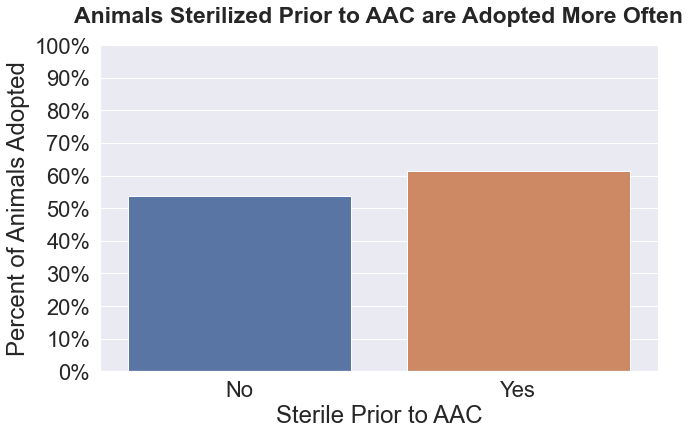

In [23]:
# grouping by sterilization status prior to AAC and aggregating % of adoptions
# within each status group
sterile_adopt = train.groupby('sterilized_income').mean()[['is_adopted']].sort_values('sterilized_income')

# changing index values to no and yes from 0 and 1, respectively
sterile_adopt.index = ['No', 'Yes']

# creating plot
plt.figure(figsize=(10, 6))
sns.barplot(data = sterile_adopt, x = sterile_adopt.index, y='is_adopted')
plt.xlabel("Sterile Prior to AAC")
plt.ylabel("Percent of Animals Adopted")
plt.title("Animals Sterilized Prior to AAC are Adopted More Often", fontweight='bold', fontsize=23, y=1.05)
fmt = [f'{i:0.0%}' for i in np.linspace(0, 1, 11)]
plt.yticks(np.linspace(0, 1, 11), labels=fmt)
plt.show()

## Chi Squared Test
### Hypothesis
<br>
H0: sterilized_income and adoption are independent
<br>
Ha: sterilized_income and adoption are dependent

In [24]:
# creating crosstab using sterilization prior to AAC and is_adopted columns
observed_sterile = pd.crosstab(train.sterilized_income, train.is_adopted)

# calculating chi^2, p value, degrees of freedom and expected values
chi2, p, degf, expected = stats.chi2_contingency(observed_sterile)

# printing results
print('alpha = .05\n')
print(f'p     = {p:.4f}')

alpha = .05

p     = 0.0000


- Since p is less than alpha, I reject the null hypothesis that income_sterilization and gender are independent


- The calculated percentages and visualization indicate that animals that a higher percent of animals sterilized prior to the AAC are adopted than those were not sterilized prior to the AAC

## Feature to Explore: Breeds that are commonly perceived as aggressive
Many people believe that there are "agressive" breeds of dogs. Dogs of these breeds may have a harder time getting adopted (Pit Bull, Rottweiler, Chow, Doberman).

In [25]:
# filtering for only rows that include dogs
dogs = train[train.species == 'dog']

# using groupby to examine adoption rates within species
agg = dogs.groupby('perceived_agg_breed').mean()[['is_adopted']]

agg

,is_adopted
perceived_agg_breed,
0,0.660154
1,0.565603


### Visualization

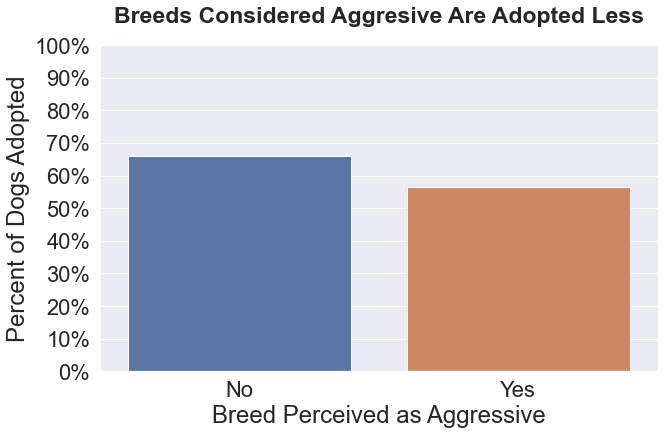

In [26]:
# changing index to no and yes from 0 and 1, respectively
agg.index = (['No', 'Yes'])

# creating plot
plt.figure(figsize=(10, 6))
sns.barplot(data=agg, x=agg.index, y='is_adopted')
plt.xlabel("Breed Perceived as Aggressive")
plt.ylabel("Percent of Dogs Adopted")
plt.title("Breeds Considered Aggresive Are Adopted Less", fontweight='bold', fontsize=23,y = 1.05)
fmt = [f'{i:0.0%}' for i in np.linspace(0, 1, 11)]
plt.yticks(np.linspace(0, 1, 11), labels=fmt)
plt.show()

### Chi-Squared Test

### Hypothesis
<br>
H0: Adoption and whether an animal is neutered of spayed are independent
<br>
Ha: Adoption and whether an animal is neutered of spayed are dependent

In [27]:
# creating crosstab using agg_breed and is_adopted columns
ct_breed = pd.crosstab(dogs.perceived_agg_breed, dogs.is_adopted)

# calculating chi^2, p value, degrees of freedom and expected values
chi2, p, degf, expected = stats.chi2_contingency(ct_breed)

# printing results
print('alpha = .05\n')
print(f'p     = {p:.4f}')

alpha = .05

p     = 0.0000


- Since p is less than alpha I am rejecting the null hypothesis that dogs of a breed that is perceived as aggressive and adoption are independent


- The calculated percentages and visualization suggest that dogs of an aggressive breed are adopted less often

### Exploration Takeaways
- A lower percentage of animals that are 10 years or older are adopted than their younger counterparts


- A percentage of dogs that are adopted is higher than the percentage of cats that are adopted


- The percentage of male and female animals adopted are nearly identical


- None of the animals in the dataset with ah unknown gender were adopted
    - Most of these animal were stray cats who were transferred to another facility
    - I'll be exploring these animals more in-depth in my upcoming expansion of this project


- The adoption percentage of animals that are sterilized prior to entering the AAC is higher than the adoption percentage of other animals


- Dogs of a breed that is perceived as aggressive are adopted less often than other breeds


- Two-sample, one-tailed t-test suggested that the average age of adopted animals is lower than the average age of animals that are not adopted


- Chi square tests showed that is_adopted and all of the following variables are not independent of each other
    - animal_type (cat or dog)
    - gender (male, female, unknown)
    - agg_breed (if a breed of dog is commonly perceived as aggressive)
    - sterilized_income (if an animal was sterilized prior to entering the AAC)

# Model<a id='model'></a>
I'll now create several models that will predict whether an animal was adopted based on it's various features.
***

## Choosing a performance metric (accuracy, recall, precision, f1-score, etc.)
- False positives (predicting an animal will be adopted when they won't) are troublesome because they can create scenarios where the AAC focuses on finding homes for animals that they think will not be adopted, while skipping over at-risk animals due to the model's false positive prediction.
- False negatives (predicting an animal won't be adopted when they actually will be) can also be troublesome since like false positives, they can create scenarios where the AAC is focusing on getting animals adopted that were going to be adopted regardless.

However, false positives are arguably more disruptive than false negatives since identifying less at-risk animals is worse than focusing on more animals that are not at-risk. For example, if the AAC posts pictures of the most at-risk animals, leaving an at-risk animal out of the group arguably does more harm than including a picture of an animal that it not at-risk.


In light of these points, I'll judge each model based on it's accuracy and precision scores.
- Accuracy gauges how often the model made a correct prediction overall
- Preicision guages the percent of true positives out of all predicted positives. So it's a good metric to use if my aim is to avoid false positives (since more false positives = lower precision).

## Baseline

In [28]:
# checking most common value of target variable
# ie. are animals more adopted more often than not?
train.is_adopted.value_counts()

1    18670
0    14904
Name: is_adopted, dtype: int64

In [29]:
# setting baseline prediction to 1
train['baseline_pred'] = 1

In [30]:
# printing performance metrics
print(classification_report(train.is_adopted, train.baseline_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     14904
           1       0.56      1.00      0.71     18670

    accuracy                           0.56     33574
   macro avg       0.28      0.50      0.36     33574
weighted avg       0.31      0.56      0.40     33574



## Train

In [31]:
# setting target variable
y_train = train['is_adopted']

### Model 1 - Logistic Regression - Train

In [32]:
# setting feature for model
X_train_m1 = train[['age_outcome_days_s', 'is_dog', 
                    'gender_unknown', 'sterilized_income', 'perceived_agg_breed']]

# creating logistic regression object
lr = LogisticRegression(random_state=123)

# fitting model to data
lr.fit(X_train_m1, y_train)

# creating column with model predictions
train['m1_prediction'] = lr.predict(X_train_m1)

# printing performance metrics
print(classification_report(train.is_adopted, train.m1_prediction))

              precision    recall  f1-score   support

           0       0.74      0.30      0.43     14904
           1       0.62      0.91      0.74     18670

    accuracy                           0.64     33574
   macro avg       0.68      0.61      0.58     33574
weighted avg       0.67      0.64      0.60     33574



### Model 2 - Random Forest - Train

In [33]:
# creating DF with selected features for logistic regression model
X_train_m2 = train[['age_outcome_days_s', 'is_dog', 
                    'gender_unknown', 'sterilized_income', 'perceived_agg_breed']]

# creating random forest object
rf = RandomForestClassifier(max_depth = 5, random_state=123)

# fitting to data
rf.fit(X_train_m2, y_train)

# making predictions
train['m2_prediction'] = rf.predict(X_train_m2)

# printing performance metrics
print(classification_report(train.is_adopted, train.m2_prediction))

              precision    recall  f1-score   support

           0       0.83      0.42      0.56     14904
           1       0.67      0.93      0.78     18670

    accuracy                           0.71     33574
   macro avg       0.75      0.68      0.67     33574
weighted avg       0.74      0.71      0.68     33574



### Model 3 - Knearest Neighbor - Train

In [34]:
# creating DF with selected features for KNN model
X_train_m3 = train[['age_outcome_days_s', 'is_dog', 
                    'gender_unknown', 'sterilized_income', 'perceived_agg_breed']]

# creating KNN object
knn = KNeighborsClassifier(n_neighbors=2, weights = 'uniform')

# fitting model to data
knn.fit(X_train_m3, y_train)

# making predictions on x train
m3_y_pred = pd.DataFrame(knn.predict(X_train_m3))

# creating column with model predictions
train['m3_prediction'] = knn.predict(X_train_m3)

# printing performance metrics
print(classification_report(train.is_adopted, train.m3_prediction))

              precision    recall  f1-score   support

           0       0.49      0.79      0.60     14904
           1       0.67      0.33      0.45     18670

    accuracy                           0.54     33574
   macro avg       0.58      0.56      0.52     33574
weighted avg       0.59      0.54      0.52     33574



## Train Sample Performance Summary

__Baseline Model__
- Precision: 56%
- Accuracy: 56%


__Model 1__
- Precision: 64%
- Accuracy: 62%


__Model 2__
- Precision: 71%
- Accuracy: 67%


__Model 3__
- Precision: 54%
- Accuracy: 67%



__Top 2 models are__
- Model 1 (logistic regression)
    - second highest accuracy (5% lower than highest) but has second highest precision after model 2 (best model thus far), 
    - beat out model 3's precision by 10%
    
    
- Model 2 (random forest)
    - tied for highest accuracy
    - has highest precision
    
    
- Models 1 and 2 will be used on the validatation set

## Validate

In [35]:
# setting target variable
y_val = validate['is_adopted']

### Model 1 - Logistic Regression - Validation - No hyperparameter tuning

__NOTE: I was not able to find any hyperparameter configuration for model 1 on the validation sample that allowed it to outperform the configuration from the training sample. With that in mind, the hyperparameter settings from the train sample will not be changed. This only applies to model 1.__

In [36]:
# setting features for model
X_val_m1 = validate[['age_outcome_days_s', 'is_dog', 
                    'gender_unknown', 'sterilized_income', 'perceived_agg_breed']]

# creating column with model predictions
validate['m1_prediction'] = lr.predict(X_val_m1)

# printing performance metrics
print(classification_report(validate.is_adopted, validate.m1_prediction))

              precision    recall  f1-score   support

           0       0.72      0.31      0.43      6318
           1       0.63      0.91      0.74      8071

    accuracy                           0.64     14389
   macro avg       0.67      0.61      0.59     14389
weighted avg       0.67      0.64      0.60     14389



### Model 2 - Random Forest - Validation - No Hyperparameter Tuning

In [37]:
# setting features for model
X_val_m2 = validate[['age_outcome_days_s', 'is_dog', 
                    'gender_unknown', 'sterilized_income', 'perceived_agg_breed']]

# creating column with model predictions
validate['m2_prediction'] = rf.predict(X_val_m2)

# printing performance metrics
print(classification_report(validate.is_adopted, validate.m2_prediction))

              precision    recall  f1-score   support

           0       0.82      0.42      0.55      6318
           1       0.67      0.93      0.78      8071

    accuracy                           0.70     14389
   macro avg       0.75      0.67      0.67     14389
weighted avg       0.74      0.70      0.68     14389



### Model 2 - Random Forest - Validation - With Hyperparameter Tuning
__NOTE: For model 2, by increasing the value set to the "max_depth" hyperparameter to 7, I was able to increase precision by 3% and accuracy by 2% at the cost of decreasing recall by 3%. This is acceptable given that precision is more important to our goal than recall.__

In [38]:
# creating random forest object
rf = RandomForestClassifier(max_depth = 7, random_state=123)

# fitting to data
rf.fit(X_train_m2, y_train)

# setting features for model
X_val_m2 = validate[['age_outcome_days_s', 'is_dog', 
                    'gender_unknown', 'sterilized_income', 'perceived_agg_breed']]

# creating column with model predictions
validate['m2_prediction'] = rf.predict(X_val_m2)

# printing performance metrics
print(classification_report(validate.is_adopted, validate.m2_prediction))

              precision    recall  f1-score   support

           0       0.80      0.50      0.61      6318
           1       0.70      0.90      0.79      8071

    accuracy                           0.72     14389
   macro avg       0.75      0.70      0.70     14389
weighted avg       0.74      0.72      0.71     14389



## Validate Sample Performance Summary

__Model 1__
- Precision: 64%
- Accuracy: 63%


__Model 2 (with hyperparameter tuning)__
- Precision: 70%
- Accuracy: 72%


- Given its better accuracy and precision on the validate sample, the random forest model proved to be the best model and will be used on test sample

## Test

### Model 2 - Random Forest

In [39]:
# setting target variable
y_test = test['is_adopted']

# setting features for model
X_test_m2 = test[['age_outcome_days_s', 'is_dog', 
                    'gender_unknown', 'sterilized_income', 'perceived_agg_breed']]

# creating column with model predictions
test['m2_prediction'] = rf.predict(X_test_m2)

# printing performance metrics
print(classification_report(test.is_adopted, test.m2_prediction))

              precision    recall  f1-score   support

           0       0.80      0.48      0.60      5476
           1       0.67      0.90      0.77      6515

    accuracy                           0.71     11991
   macro avg       0.74      0.69      0.69     11991
weighted avg       0.73      0.71      0.69     11991



## Test Sample Performance Summary
- Random forest model 
    - Precision: 67%
    - Accuracy: 71%
    - Proved to be the best model on both in-sample and out-of-sample data

## Modeling Takeaways

__Created models using the following algorithms__
- logistic regression
- random forest
- k-nearest neighbor


__Train Set Model Performances__
    
- Baseline Model
    - Precision: 56%
    - Accuracy: 56%


- Model 1 (Logistic Regression)
    - Precision: 64%
    - Accuracy: 62%


- Model 2 (Random Forest)
    - Precision: 71%
    - Accuracy: 67%


- Model 3 (K-Nearest Neighbor)
    - Precision: 54%
    - Accuracy: 67%    
    
    
__Validate Set Model Performances__
- Model 1 (Logistic Regression)
    - Precision: 63%
    - Accuracy: 64%


- Model 2 (Random Forest)
    - Precision: 70%
    - Accuracy: 72%



__Test Set Model Performance__
- Model 2 (Random forest)
    - Precision: 67%
    - Accuracy: 71%
       

# Conclusion<a id='conclusion'></a>

### Acquire
- Acquired data from local csv file

### Prepare
- Prepped data with various changes, namely:
    - Dropped columns for various reason
        - Some will be restored and explore in a future iteration of this project
    - Split column that contained gender and sterilization at time of intake information
    - Added boolean columns for categorical data
    - Renamed columns
    - Dropped null values
    - Split Data
    
### Explore
- A lower percentage of animals that are 10 years or older are adopted than their younger counterparts


- A percentage of dogs that are adopted is higher than the percentage of cats that are adopted


- The percentage of male and female animals adopted are nearly identical


- None of the animals in the dataset with ah unknown gender were adopted
    - Most of these animal were stray cats who were transferred to another facility
    - I'll be exploring these animals more in-depth in my upcoming expansion of this project


- The adoption percentage of animals that are sterilized prior to entering the AAC is higher than the adoption percentage of other animals


- Dogs of a breed that is perceived as aggressive are adopted less often than other breeds


- Two-sample, one-tailed t-test suggested that the average age of adopted animals is lower than the average age of animals that are not adopted


- Chi square tests showed that is_adopted and all of the following variables are not independent of each other
    - animal_type (cat or dog)
    - gender (male, female, unknown)
    - agg_breed (if a breed of dog is commonly perceived as aggressive)
    - sterilized_income (if an animal was sterilized prior to entering the AAC)
    
### Model
- Created baseline model that produced 56% accuracy on train data


- Created 3 alternate models using various algorithms


- Best Model was created with the following profile
    - Type: Random Forest
    - Features: 
        - age_outcome_days_s (animal's age)
        - is_dog (represents if animal is a dog)
        - gender_unknown (if animal's gender is unknown)
        - sterilized_income (if animal was sterile at time of intake into AAC)
        - perceived_agg_breed (if animal's breed is commonly perceived as aggressive)
        
        
- Best model performance on test sample
    - Model 2 (Random forest)
    - Precision: 67%
    - Accuracy: 71%

### Recommendations
- Develop a program that aims to pair older animals with suitable homes
- Sterilize animals prior to adoption
- Use website and promotional material to advocate for increased cat adoption

### Predictions
- By following the recommendations above, the AAC may be able to increase their adoption rates

### Plans for the future
- I'd like to explore the features that I was not able to explore in this iteration of the project in the interest of time.